In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\Jared\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Jared\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Jared\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Get Sherlock Holmes Data

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./sherlock.txt').read().strip()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 3378006
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the sherlock dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        if char in all_chars:
            index = all_chars.index(char)
            tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        if char in all_chars:
            tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


# Define RNN 

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100. Hyperparameter 
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        
        self.rnn = nn.RNNCell(self.input_size, self.hidden_size)
        self.rnn2 = nn.RNNCell(self.hidden_size, self.hidden_size)
        
        self.lin = nn.Linear(self.hidden_size, self.output_size)
        
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. 
              hidden: Previous hidden state.
            Returns (output, hidden) 
        """
        # Forward function.
        
        # Create updated hidden layer
        hidden = self.rnn(input, hidden)
        hidden = self.rnn2(hidden, hidden)
        
        # Create output
        output = self.lin(hidden)
        
        
        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device)
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 100)
  (rnn2): RNNCell(100, 100)
  (lin): Linear(in_features=100, out_features=100, bias=True)
)

# Create Functions for Training and Evaluation

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

# Training

In [16]:
# Number of iterations.
iters       = 30000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
learning_rate = 0.001 # Hyperparameter
opt       = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum.item() / print_iters)
        loss_sum = 0

iter:99/30000 loss:1.5576069355010986
generated sequence: Whan the little yeaturast. Shemplowed to little harden man hermood an of a wasge sowning it?" He one-

iter:199/30000 loss:1.5446606874465942
generated sequence: What

     "As his manuned a morn been hould even of the room! Dorm sidemate eye grew clepe-how ruppe

iter:299/30000 loss:1.5372602939605713
generated sequence: Wolmess atclature who very this opened. In us same the brivistens to him too inthents coipage
     he

iter:399/30000 loss:1.5545850992202759
generated sequence: Well 
     "Sure, reaming, withing
     him if I am tho lotes and yet reem infiry, hyive were a
     

iter:499/30000 loss:1.5543795824050903
generated sequence: When me,' he assoory
     enough and
     comeful. Then, which withink were harfifures which his mer 

iter:599/30000 loss:1.5619828701019287
generated sequence: We seed huppilise flowf a stranged uping way, Mr. But one ston," said Hexpled
     trusce my contenea

iter:699/30000 loss:1.5535157

iter:5199/30000 loss:1.526546835899353
generated sequence: Where
     have met to ussed mind. But It is anttinal voung you laid   looking suct the disred daifed

iter:5299/30000 loss:1.521429181098938
generated sequence: When if I ficce over askion. You cannop with track wa whom hard, and not has to down up at compogly m

iter:5399/30000 loss:1.5375514030456543
generated sequence: What theremer. Theyever." Mr. "And on the mree insting. Holdor when me a fude mely boxsed when I who 

iter:5499/30000 loss:1.5484869480133057
generated sequence: What I lifunul of
     by the unntcable Caperts
     of dread at out gloths lead volucative them, hav

iter:5599/30000 loss:1.4925589561462402
generated sequence: Was her to
     he said he."

     "It was devard staod
     to his hand when he is a stepean gosted 

iter:5699/30000 loss:1.5194603204727173
generated sequence: What con!" Coursfulle.
     Thet-her messed, and sare as I rebestions I dizase round."

     "I who?"

iter:5799/30000 loss:1.5

iter:10299/30000 loss:1.5118217468261719
generated sequence: Who had
     usmed. I had in the heady at own spear wave agage the
     plapulonessward."

     "A ca

iter:10399/30000 loss:1.5284101963043213
generated sequence: We were nothing to by flackry of the poake me, to desse depue he,
     in that had recoam stove
     

iter:10499/30000 loss:1.5253121852874756
generated sequence: When the lain, so."

     "And him only dark by the indy it I could onon you will showed through imom

iter:10599/30000 loss:1.5546274185180664
generated sequence: Watches. Bundle his nexts of Pisuroarer hear legdle
     profes a head in the Uchemt--but he ralutith

iter:10699/30000 loss:1.51082444190979
generated sequence: Whake
     that
     she shank, a showed to ust shatter a an had faxts wactmut nefvere, Mr. Hom his l

iter:10799/30000 loss:1.501684546470642
generated sequence: Will his cross how the Desposs thessons.
     He could
     a cagnurg had a veriffing
     greaty had

iter:10899/30000 lo

iter:15399/30000 loss:1.5000450611114502
generated sequence: Walmed her is is forut a mation."

     "They it, his pook an ears."

     "P night the last Escange 

iter:15499/30000 loss:1.5220746994018555
generated sequence: Whank would been I coAre tupped emphent behind a dix shis doubt in all thing of my
     care milled a

iter:15599/30000 loss:1.519712209701538
generated sequence: We aid this his up have has out of the husiad purcy before a cound interning lett, not to been comitt

iter:15699/30000 loss:1.5088518857955933
generated sequence: What reader, as for a
     abiss upon eyes.

     "Yes; carriscands
     with from the brights.

    

iter:15799/30000 loss:1.5547819137573242
generated sequence: Who long threar, and sirunged
     hopes thet I leot as he crock roof."

     Hop, sil through any sp

iter:15899/30000 loss:1.5001705884933472
generated sequence: Was never, and off that that

     "And obs you said and case, and."

     "'Then, and is the more wi

iter:15999/30000 

iter:20399/30000 loss:1.5147290229797363
generated sequence: What tell hear furles of a glain. You, and is not who do fullap in it, will?"

     "They will made a

iter:20499/30000 loss:1.4921433925628662
generated sequence: Whor oF to rememply have suf which on us eyes cellement upon sproping; and his conning inselves.
    

iter:20599/30000 loss:1.5091110467910767
generated sequence: What
     matter--"I could a veryone it."

     "Yes, but he'll three
     the own loved from the doo

iter:20699/30000 loss:1.475501537322998
generated sequence: Was burked a steir
     fact offiched,
     and could him So helf."

     lecked of my course I can k

iter:20799/30000 loss:1.493558406829834
generated sequence: Will betait, as rece
     was promed strandency, which lath ten of Ending eals open, and. Dock pront.

iter:20899/30000 loss:1.5416276454925537
generated sequence: When then who past a chay the pashed-seal. His paint.
     you have been mine from the situally of tr

iter:20999/30000 l

iter:25399/30000 loss:1.4841920137405396
generated sequence: Whoweled. I gun the don't no know why have face her, and I ventre yourpingen?"

     "On the sionits 

iter:25499/30000 loss:1.4861809015274048
generated sequence: Wen the will back to his
     bikemness naturesflo you the life her which is, it had
     use Stret w

iter:25599/30000 loss:1.5204010009765625
generated sequence: We'd that there was betrethes,  Is imovesoms broat fellary. His head., ungortage track
     forather 

iter:25699/30000 loss:1.528820514678955
generated sequence: We mat Some boust, and us as her staur Mornin."

     "And been your eyes, but."

     "I knows. Abso

iter:25799/30000 loss:1.5116955041885376
generated sequence: Will very riefulies to myseld it."

     He was
     put the secred, which he chots of the rolabion g

iter:25899/30000 loss:1.5105335712432861
generated sequence: Watted duttered him. "Gestire of which I
     enven to him. It we not now I know then you trouble wai

iter:25999/30000 

# Loss Curve

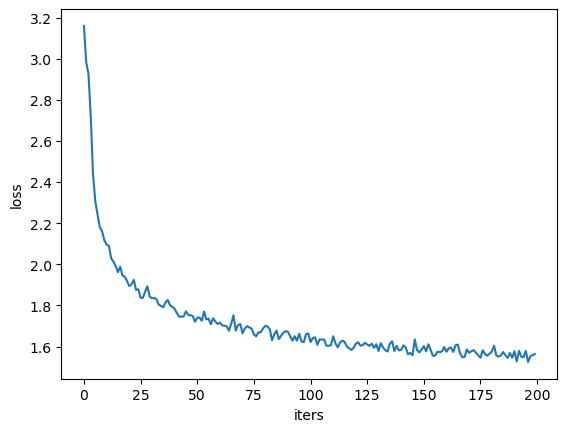

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

### I did an extra 30,000 iterations, this is that graph

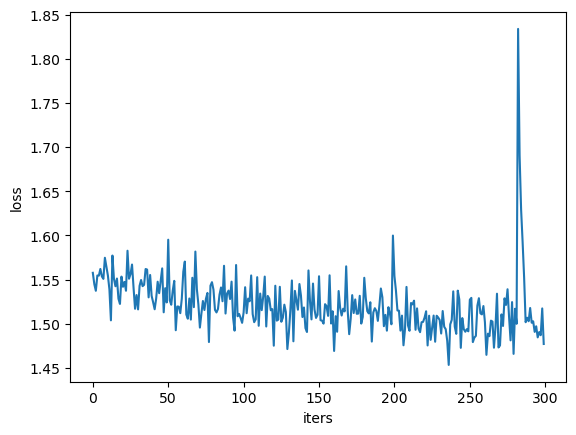

In [17]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

# Sample of Generated Sequence

In [26]:
print(eval_step(net, init_seq='W', predicted_len=1000))

We were has, were close half with Lostiting
     papfe sometilly, well body
     denat how and teln."

     This leaglacted that we
     thought with the Cas poisting told tiresitely for the dariar. "The so riffice. Watson, Couplairstand, which wableatate. That complete you might
     real be way, of looked the that his
     pailarryosm infounted brother dowerelst."

     "I house for
     then, all        to yet. He love ten-eventor you dot'y, you, my vis dittle upon a rushing with hes moorfoinitfate to gene well addoad.

     "Well.

     "Wated to rist premarking.

     "It was agrouse. Well such the losewisters matt Watson her Ettening.

     "He convice bbon helpintener
     clause upon the saw aboutoo it in though, what awis seemed. We down

     "Holds of "I dack mis in the fate." Mame, so no serall," said, us has?"

     "E auther down Brot gated to must dun oussin, Will find there us. I'll assoar been had quarty just fande that the may."

     "Dady Colkand retuloisping upon h